# Extension of Locality Sensitive Hashing to a Classification Model

Goal: attempt to extend the LSH outputs into a CNN model for image classification. 

Note: A Tensorflow-GPU kernel was used for this portion, but data are trivial enough that it should not be difficult on a CPU

In [71]:
import os
import pickle

import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from skimage.io import imread
from skimage.transform import resize

from src.Fly import Flylsh as Fly
from src.utils import benchmark

import matplotlib.pyplot as plt
%matplotlib inline

### Load LSH (computed in LSH_clustering) and Yale Face data

In [2]:
# read and reshape hashes
pickle_in = open(os.path.join("results", "face_hashes_hashlen_0.05k.pkl"),"rb")
hashes = pickle.load(pickle_in)
print (hashes.shape)
temp = np.array([xx.toarray() for xx in hashes])
print (temp.shape)
hashes = np.squeeze(temp, axis=(2,))
print (hashes.shape)
# print (hashes)

faces = [os.path.join("data","yalefaces", img) for img in os.listdir(os.path.join("data","yalefaces")) if img.startswith("subject")]
labels = [int(f.split("subject")[-1][:2]) for f in faces]
data = np.array([np.flipud(imread(faces[i])) for i in range(len(faces))])
input_row_data = data    # secondary reference to maintain original data obj
input_data = np.array(data)

(166,)
(166, 81920, 1)
(166, 81920)


### Pepare labels for clustering
These are given by the subject number

In [3]:
num_kind = 15
ind = np.array([158, 145, 162, 165, 135, 110, 95, 100, 80, 60, 65, 38, 30, 15, 3])
print ([labels[i] for i in ind])

labels = np.array(labels)
label_out = np.zeros((labels.shape[0], num_kind))
for i in range(len(labels)):
    label_out[i][labels[i]-1] = 1

train_mask = np.ones(np.array(labels).shape, bool)
train_mask[ind] = False
train_labels = label_out[train_mask]

test_mask = np.invert(train_mask)
test_labels = label_out[test_mask]

print (train_labels.shape)
print (test_labels.shape)



[15, 14, 15, 15, 13, 10, 9, 10, 8, 6, 6, 4, 3, 2, 1]
(151, 15)
(15, 15)


### Prepare raw and processed data, for feeding into NN

In [4]:
# prepare row data
row_data = input_row_data.reshape((input_row_data.shape[0], input_row_data.shape[1] * input_row_data.shape[2]))
train_row_data = row_data[train_mask]
test_row_data = row_data[test_mask]

print (row_data.shape)
print (train_row_data.shape)
print (test_row_data.shape)

(166, 77760)
(151, 77760)
(15, 77760)


In [5]:
# prepare resized data
resize_64 = [resize(img, (64, 64), anti_aliasing=True) for img in data]
input_data = np.array(resize_64)
resized_data = input_data.reshape((input_data.shape[0], input_data.shape[1] * input_data.shape[2]))
train_resized_data = resized_data[train_mask]
test_resized_data = resized_data[test_mask]

print (resized_data.shape)
print (train_resized_data.shape)
print (test_resized_data.shape)

C:\Users\bcech\Anaconda3\envs\tf-gpu\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(166, 4096)
(151, 4096)
(15, 4096)


In [6]:
# prepare fly data
train_hashes = hashes[train_mask]
test_hashes = hashes[test_mask]

print (hashes.shape)
print (train_hashes.shape)
print (test_hashes.shape)

(166, 81920)
(151, 81920)
(15, 81920)


## Create Keras Deep Network Model for full Images

In [7]:
# model for raw input: input_dim=(243, 320)= 77760
model = Sequential()
model.add(Dense(1280, input_dim=77760, activation='relu'))
model.add(Dense(15, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### And train it

In [8]:
model.fit(train_row_data, train_labels, epochs=15)

Epoch 1/15
151/151 [==============================] - 5s 33ms/step - loss: 15.0507 - acc: 0.0662
Epoch 2/15
151/151 [==============================] - 0s 3ms/step - loss: 15.0507 - acc: 0.0662
Epoch 3/15
151/151 [==============================] - 0s 3ms/step - loss: 15.0507 - acc: 0.0662
Epoch 4/15
151/151 [==============================] - 0s 3ms/step - loss: 15.0507 - acc: 0.0662
Epoch 5/15
151/151 [==============================] - 0s 3ms/step - loss: 15.0507 - acc: 0.0662
Epoch 6/15
151/151 [==============================] - 0s 3ms/step - loss: 15.0507 - acc: 0.0662
Epoch 7/15
151/151 [==============================] - 0s 3ms/step - loss: 15.0507 - acc: 0.0662
Epoch 8/15
151/151 [==============================] - 0s 3ms/step - loss: 15.0507 - acc: 0.0662
Epoch 9/15
151/151 [==============================] - 0s 3ms/step - loss: 15.0507 - acc: 0.0662
Epoch 10/15
151/151 [==============================] - 0s 3ms/step - loss: 15.0507 - acc: 0.0662
Epoch 11/15
151/151 [=================

### Model Evaluation

In [9]:
model.evaluate(test_row_data, test_labels)

15/15 [==============================] - 0s 3ms/step


[16.11809539794922, 0.0]

### Save history to compare

In [10]:
cnn_243_history = model.history.history

## Alternative CNN for resized (64x64) images

In [11]:
model = Sequential()
model.add(Reshape((64, 64, 1), input_shape=(4096,)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(15, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.fit(train_resized_data, train_labels, epochs=15)

Epoch 1/15
151/151 [==============================] - 1s 9ms/step - loss: 5.3905 - acc: 0.0927
Epoch 2/15
151/151 [==============================] - 0s 779us/step - loss: 2.0029 - acc: 0.3907 0s - loss: 2.1267 - acc: 0.312
Epoch 3/15
151/151 [==============================] - 0s 779us/step - loss: 1.0105 - acc: 0.7351
Epoch 4/15
151/151 [==============================] - 0s 773us/step - loss: 0.2882 - acc: 0.9205
Epoch 5/15
151/151 [==============================] - 0s 766us/step - loss: 0.2017 - acc: 0.9205
Epoch 6/15
151/151 [==============================] - 0s 780us/step - loss: 0.0829 - acc: 0.9934
Epoch 7/15
151/151 [==============================] - 0s 773us/step - loss: 0.0158 - acc: 1.0000
Epoch 8/15
151/151 [==============================] - 0s 773us/step - loss: 0.0052 - acc: 1.0000
Epoch 9/15
151/151 [==============================] - 0s 780us/step - loss: 0.0033 - acc: 1.0000
Epoch 10/15
151/151 [==============================] - 0s 780us/step - loss: 0.0022 - acc: 1.0000


### Model evaluation

In [13]:
model.evaluate(test_resized_data, test_labels)

15/15 [==============================] - 0s 5ms/step


[0.242208793759346, 0.9333333373069763]

### Save history to compare

In [14]:
cnn_64_history = model.history.history

## Alternative Deep Network for Fly LSH data

In [79]:
print (train_labels.shape)
model = Sequential()
model.add(Dense(256, activation='relu'))
model.add(Dense(15, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

(151, 15)


In [80]:
model.fit(train_hashes, train_labels, epochs=15, shuffle=True)

Epoch 1/15
151/151 [==============================] - 1s 6ms/step - loss: 2.7089 - acc: 0.0861
Epoch 2/15
151/151 [==============================] - 0s 1ms/step - loss: 2.7045 - acc: 0.1987
Epoch 3/15
151/151 [==============================] - 0s 1ms/step - loss: 2.6999 - acc: 0.1987
Epoch 4/15
151/151 [==============================] - 0s 1ms/step - loss: 2.6958 - acc: 0.1921
Epoch 5/15
151/151 [==============================] - 0s 1ms/step - loss: 2.6906 - acc: 0.2450
Epoch 6/15
151/151 [==============================] - 0s 1ms/step - loss: 2.6857 - acc: 0.2649
Epoch 7/15
151/151 [==============================] - 0s 1ms/step - loss: 2.6802 - acc: 0.2715
Epoch 8/15
151/151 [==============================] - 0s 1ms/step - loss: 2.6746 - acc: 0.2119
Epoch 9/15
151/151 [==============================] - 0s 1ms/step - loss: 2.6683 - acc: 0.2848
Epoch 10/15
151/151 [==============================] - 0s 1ms/step - loss: 2.6618 - acc: 0.2914
Epoch 11/15
151/151 [============================

### Fly LSH + CNN Model evaluation

In [17]:
model.evaluate(test_hashes, test_labels)

15/15 [==============================] - 0s 4ms/step


[2.6520156860351562, 0.20000000298023224]

### Save history to compare

In [18]:
cnn_lsh_history = model.history.history

## Compare 'vanilla' CNNs vs. CNN with LSH as input

In [61]:
# plot each of the models' losses and accuracy over training epochs
epochs = range(1,16)

# cnn_243
y_loss_243 = cnn_243_history['loss']
y_acc_243 = cnn_243_history['acc']

# cnn_64
y_loss_64 = cnn_64_history['loss']
y_acc_64 = cnn_64_history['acc']

# cnn_lsh
y_loss_lsh = cnn_lsh_history['loss']
y_acc_lsh = cnn_lsh_history['acc']

# fig, ax1 = plt.subplots(figsize=(8,5))

# ax1.set_ylabel('Loss', color='black')
# #ax1.plot(t, dataL, color=color)
# ax1.plot(epochs, y_loss_243, marker='x', markerfacecolor='blue', markersize=8, color='skyblue', linewidth=2)
# ax1.plot(epochs, y_loss_64, marker='1', markerfacecolor='red', markersize=8, color='red', linewidth=2)
# ax1.plot(epochs, y_loss_lsh, marker='.', markerfacecolor='black', markersize=8, color='black', linewidth=2)

# ax1.tick_params(axis='y', labelcolor='black')

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# ax2.set_ylabel('Accuracy', color='black')  # we already handled the x-label with ax1
# ax2.plot(epochs, y_acc_243, marker='x', color='blue', linewidth=2)
# ax2.plot(epochs, y_acc_64, marker='1', color='magenta', linewidth=2)
# ax2.plot(epochs, y_acc_lsh, marker='.', color='grey', linewidth=2)
# ax2.tick_params(axis='y', labelcolor='black')

# fig.legend(('243_loss', '64_loss', 'lsh_loss', '243_acc', '64_acc', 'lsh_acc'), loc='center')
# plt.title("Accuracy and Loss over 15 epochs of CNN training")
# plt.show();

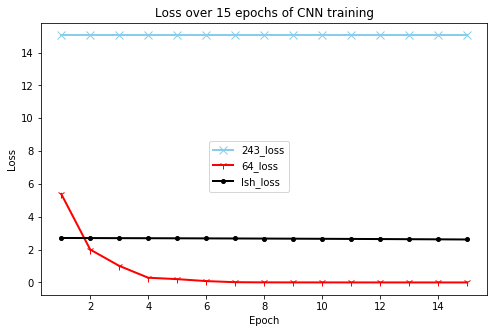

In [62]:
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(epochs, y_loss_243, marker='x', markerfacecolor='blue', markersize=8, color='skyblue', linewidth=2)
ax1.plot(epochs, y_loss_64, marker='1', markerfacecolor='red', markersize=8, color='red', linewidth=2)
ax1.plot(epochs, y_loss_lsh, marker='.', markerfacecolor='black', markersize=8, color='black', linewidth=2)

fig.legend(('243_loss', '64_loss', 'lsh_loss'), loc='center')
plt.title("Loss over 15 epochs of CNN training")
ax1.set_ylabel('Loss', color='black')
ax1.set_xlabel('Epoch', color='black')

plt.show();

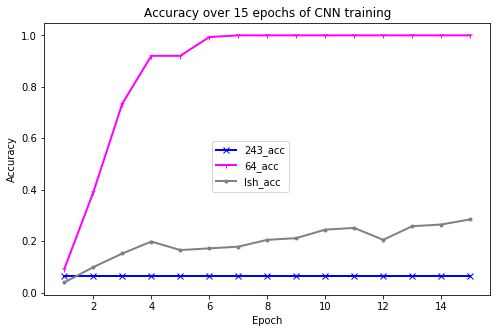

In [63]:
fig, ax2 = plt.subplots(figsize=(8,5))

ax2.plot(epochs, y_acc_243, marker='x', color='blue', linewidth=2)
ax2.plot(epochs, y_acc_64, marker='1', color='magenta', linewidth=2)
ax2.plot(epochs, y_acc_lsh, marker='.', color='grey', linewidth=2)

fig.legend(('243_acc', '64_acc', 'lsh_acc'), loc='center')
plt.title("Accuracy over 15 epochs of CNN training")
ax2.set_ylabel('Accuracy', color='black')
ax2.set_xlabel('Epoch', color='black')
ax2.tick_params(axis='y', labelcolor='black')

plt.show();